# **AUTOENCODERS**

## **Implementacion**

### **Multilayer MLP**

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

from random import uniform, shuffle
from sklearn.datasets import load_digits
from skimage.util import random_noise
from math import e

In [2]:
class MLP:
  """ 
  Implementacion de un perceptron multicapa (MLP: Multi-Layer Perceptron) 
  usando el descenso de gradiente estocastico con momentum como algoritmo de 
  entrenamiento. 
  """

  def __init__(self, eta: float, dim_input: int, alpha: float = 0):
    """
    Inicializacion del perceptron multicapa.

    INPUT:
      - eta:  Tasa de aprendizaje.
      - dim_input:  Dimension de los datos de entrada.
      - alpha:  Momentum. Valor predeterminado: 0.
    """
    self.eta = eta
    self.dim_input = dim_input
    self.alpha = alpha
    # Pesos sinapticos de cada capa.
    self.W = []
    # Funcion de activacion en cada capa y sus respectivas derivadas.
    self.act_functions = []
    self.derived_act_functs = []
    # Dimension de los datos de salida.
    self.dim_output = dim_input


  def add_layer(self, dim: int, phi, dphi, w_min: float = -0.05, w_max: float = 0.05):
    """ 
    Agrega una nueva capa a la red neuronal.

    INPUT:
      - dim:  Numero de neuronas de la capa.
      - phi:  Funcion de activacion.
      - dphi: Derivada de la funcion de activacion.
      - w_min:  Valor minimo de los pesos sinapticos al inicializarlos aleatoriamente.
                Valor predeterminado: -0.05.
      - w_max:  Valor maximo de los pesos sinapticos al inicializarlos aleatoriamente.
                Valor predeterminado: 0.05.
    """
    w = np.random.uniform(low=w_min, high=w_max, size=(dim, self.dim_output + 1))
    self.W.append(w)
    self.act_functions.append(phi)
    self.derived_act_functs.append(dphi)
    # Actualizamos la nueva dimension de los datos de salida.
    self.dim_output = dim


  def predict(self, x: [float]):
    """
    Predice el valor de un dato de entrada.

    INPUT:
      - x:  Dato de entrada

    OUTPUT:
      - [float]:  Clasificacion predicha.
    """
    y = x
    # Por cada capa de la red.
    for k in range(len(self.W)):
      # Insertamos un 1 al resultado de la capa anterior para el sesgo. Luego
      # lo multiplicamos por la matriz de pesos correspondiente a esta capa.
      y = np.append(y, [1])
      A = np.dot(self.W[k], y)
      y = [self.act_functions[k](A[i]) for i in range(len(A))]
    return y


  def predict_train(self, x: [float]):
    """
    Predice el valor de un dato de entrada, almacenando la vecindad y el output
    de cada neurona para usarlos en el entrenamiento.

    INPUT:
      - x:  Dato de entrada

    OUTPUT:
      - [[float]]:  Ouput de cada neurona.
      - [[float]]:  Input de cada neurona.
    """
    # Numero de capas de la red.
    n_layers = len(self.W)
    # Output e input de cada neurona.
    Y, V = [0]*n_layers, [0]*n_layers

    # Para cada k-esima capa de la red seguimos la formula
    # V[k] = W[k]Y[k-1]
    # Y[k] = phi[k](V[k])
    V[0] = np.dot(self.W[0], np.append(x, 1))
    Y[0] = np.array([self.act_functions[0](V[0][i].copy()) for i in range(len(V[0]))])
    for k in range(1, n_layers):
      V[k] = np.dot(self.W[k], np.append(Y[k-1], 1))
      Y[k] = np.array([self.act_functions[k](V[k][i].copy()) for i in range(len(V[k]))])
    return Y, V


  def ecmp(self, X: [[float]], Y: [[float]]):
    """ 
    Error cuadratico medio promediado obtenido para un conjunto de datos.

    INPUT:
      - X:  Conjunto de datos de entrada.
      - Y:  Conjunto de datos de salida.

    OUTPUT:
      - float:  Error cuadratico medio promediado.
    """
    # Numero de datos a clasificar.
    N = len(X)
    err = 0
    for j in range(N):
      d_j = Y[j]
      # Predecimos el valor del j-esimo dato de entrada.
      y_j = self.predict(X[j])
      # Sumamos la diferencia entre lo predicho y el valor correcto.
      err += np.dot(d_j-y_j, d_j-y_j)
    return err/(2*N)


  def train(self, X_train: [[float]],   Y_train: [[float]],  epochs: int,  
            ecmp_min: float = 0, sparse=False, p=0.05, b=0.01, verbose: bool = True):
    """
    Entrena a la red con un conjunto de entrenamiento y otro de prueba durante
    un numero de epocas determinado.

    INPUT:
      - X_train:  Conjunto de datos de entrenamiento de entrada.
      - Y_train:  Conjunto de datos de entrenamiento de salida.
      - epochs:   Numero de epocas.
      - ecmp_min:  Error cuadratico medio promediado necesario para finalizar el 
          entrenamiento. Valor predeterminao: 0.
      - verbose:  Indica si se imprimiran los datos obtenidos en cada epoca.

    OUTPUT:
      - [float]:  Error cuadratico medio promediado obtenido de los datos de
                entrenamiento en cada epoca.
      - [float]:  Error cuadratico medio promediado obtenido de los datos de
                prueba en cada epoca
        Si se especifica una funcion de activacion:
      * [float]:  Precision obtenida de los datos de entrenamiento en cada epoca.
      * [float]:  Precision obtenida de los datos de prueba en cada epoca
    """

    N = len(X_train)
    indexes = [i for i in range(N)]
    n_layers = len(self.W)
    # Error cuadratico medio obtenido con los datos de entrenamiento
    # y prueba en cada epoca.
    ecm_train = []
    # Activacion de cada neurona
    P = []

    # Variacion de los pesos.
    varW = [np.array([np.array([0 for _ in w_i]) for w_i in w]) for w in self.W]

    if not verbose: print("Epochs: [" + " "*epochs + "]")

    for i in range(epochs):
      shuffle(indexes)
      # Gradiente local de cada neurona.
      delta = [0]*n_layers

      for j in indexes:
        d_j = Y_train[j]
        x_j = X_train[j]
        Y, V = self.predict_train(x_j)

        # Calculamos el gradiente local de las neuronas en la ultima capa.
        if sparse:
          delta[n_layers-1] = [(d_j - Y[len(Y)-1])[k] * \
                self.derived_act_functs[n_layers-1](V[n_layers-1][k]) for k in range(len(V[n_layers-1]))]
        else:
          p_k += 
          delta[n_layers-1] = [(d_j - Y[len(Y)-1])[k] * \
                self.derived_act_functs[n_layers-1](V[n_layers-1][k]) for k in range(len(V[n_layers-1]))]
        # Verificamos que no estemos en la primera capa.
        y_j = Y[len(Y)-2] if len(Y) > 1 else x_j
        # Calculamos la variacion de los pesos.
        varW[n_layers-1] = self.eta * np.outer(delta[n_layers-1], np.append(y_j, 1)) + \
          self.alpha * varW[n_layers - 1] 
        # Actualizamos los pesos.
        self.W[n_layers-1] += varW[n_layers-1]

        # BackPropagation.
        for k in range(n_layers-2, -1, -1):
          # Verificamos que no estemos en la primera capa.
          outp_k = Y[k-1] if k > 0 else x_j
          # Calculamos el gradiente local de las neuronas de la k-esima capa.
          delta[k] = [self.derived_act_functs[k](V[k][h]) * \
            np.dot(delta[k+1], np.transpose(self.W[k+1])[h]) for h in range(len(V[k]))]
          # Calculamos la variacion de los pesos.
          varW[k] = self.eta * np.outer(delta[k], np.append(outp_k, 1)) + self.alpha*varW[k]
          # Actualizamos los pesos.
          self.W[k] += varW[k]

      # Calculamos y almacenamos los errores cuadraticos medios promediados.
      new_ecm_train = self.ecmp(X_train, Y_train)
      ecm_train.append(new_ecm_train)
      if verbose:
        print("Epoch:", i+1, "| ECMP datos de entrenamiento:", new_ecm_train)
      else: print("\b"*(11 + epochs) + "Epochs: [" + "#"*(i+1) + " "*(epochs-i-1) + "]")

      # Si alcanzamos el error minimo, finalizamos el entrenamiento.
      if new_ecm_train <= ecmp_min:
        break

    else:
      return ecm_train

### **Activation Functions**

In [3]:
def logist(x: float, alpha: float = 1):
  """ Funcion logistica.  
    logist(x) -> 1/(1 + exp(-alpha*x)) 
  """
  return 1/(1+e**(-alpha*x))


def d_logist(x: float, alpha: float = 1):
  """ Derivada de la funcion logistica. 
    d_logist(x) -> alpha*logist(x)(1 - logist(x))"""
  l = logist(x, alpha = alpha)
  return alpha*l*(1 - l) 

## **Lectura de Datos**

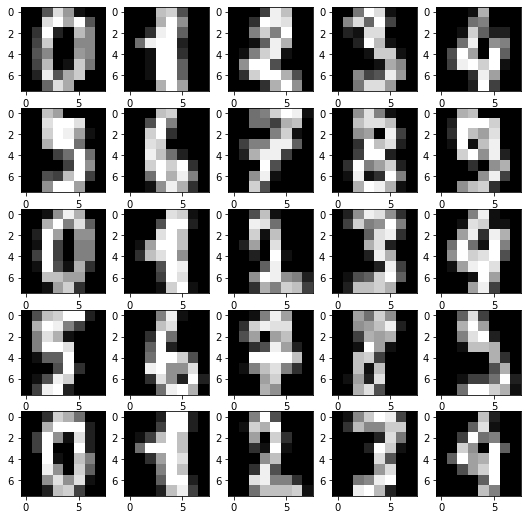

In [24]:
digits = load_digits()
X = digits['data'] / np.max(digits['data'])
X_train = X[:1400]
X_test = X[1400:]

# Mostramos algunos datos
fig = plt.figure(figsize=(9,9))
for i in range(5):
  for j in range(5):
    fig.add_subplot(5,5,1+i*5+j)
    first_image = np.array(X[i*5+j], dtype='float64')
    pixels = first_image.reshape((8, 8))
    plt.imshow(pixels, cmap='gray')
plt.show()

## **Resultados**

### **Dimensionality Reduction**

In [26]:
mlp = MLP(0.1, 64, 0.35)
mlp.add_layer(8, logist, d_logist)
mlp.add_layer(64, logist, d_logist)
# Entrenamos la red.
ecm = mlp.train(X_train, X_train, 50) 

Epoch: 1 | ECMP datos de entrenamiento: 2.4098237520722785
Epoch: 2 | ECMP datos de entrenamiento: 1.814327367071453
Epoch: 3 | ECMP datos de entrenamiento: 1.3105864625159123
Epoch: 4 | ECMP datos de entrenamiento: 1.0756381655234926
Epoch: 5 | ECMP datos de entrenamiento: 0.9355834201101011
Epoch: 6 | ECMP datos de entrenamiento: 0.8584593052026025
Epoch: 7 | ECMP datos de entrenamiento: 0.8314649440290137
Epoch: 8 | ECMP datos de entrenamiento: 0.8022909951297676
Epoch: 9 | ECMP datos de entrenamiento: 0.7957077423689108
Epoch: 10 | ECMP datos de entrenamiento: 0.7855332778111992
Epoch: 11 | ECMP datos de entrenamiento: 0.7795235862908013
Epoch: 12 | ECMP datos de entrenamiento: 0.7672954157151987
Epoch: 13 | ECMP datos de entrenamiento: 0.7536026694248541
Epoch: 14 | ECMP datos de entrenamiento: 0.7516273199908811
Epoch: 15 | ECMP datos de entrenamiento: 0.749560887922483
Epoch: 16 | ECMP datos de entrenamiento: 0.7373541927663549
Epoch: 17 | ECMP datos de entrenamiento: 0.73428758

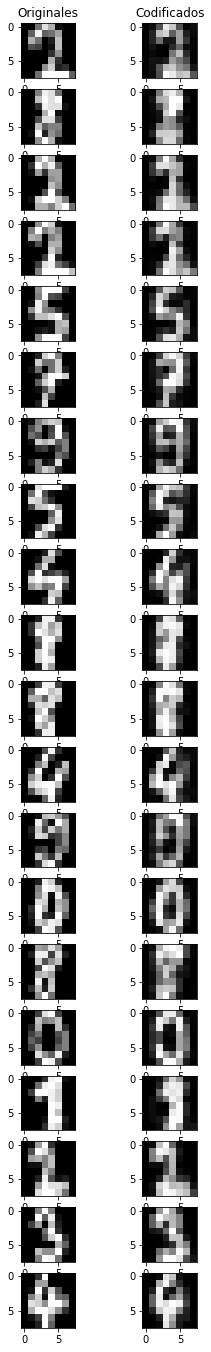

In [27]:
# Mostramos algunos datos
fig = plt.figure(figsize=(4,24))
for i in range(20):
    fig.add_subplot(20,2,1+i*2)
    if i == 0: plt.title("Originales")  
    first_image = np.array(X_test[i], dtype='float64')
    pixels = first_image.reshape((8, 8))
    plt.imshow(pixels, cmap='gray')
    
    fig.add_subplot(20,2,2+i*2)
    if i == 0: plt.title("Codificados")
    first_image = np.array(mlp.predict(X_test[i]), dtype='float64')
    pixels = first_image.reshape((8, 8))
    plt.imshow(pixels, cmap='gray')
plt.show()


### **Denoising**

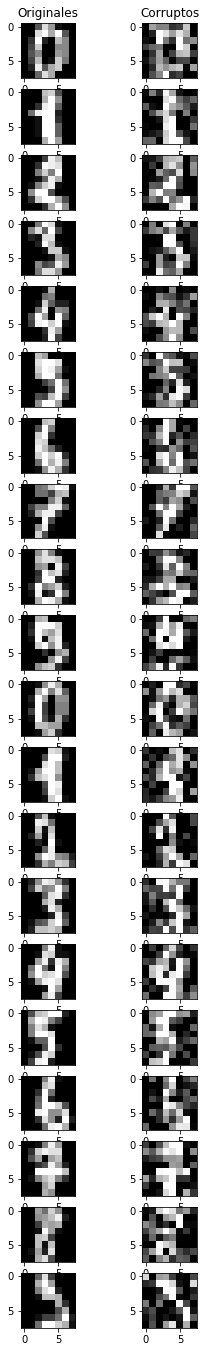

In [28]:
# Agregamos ruido a las imagenes.
X_train_c = [random_noise(x, mode='gaussian', var=0.1) for x in X_train]
X_test_c = [random_noise(x, mode='gaussian', var=0.1) for x in X_test]

# Mostramos algunos datos
fig = plt.figure(figsize=(4,24))
for i in range(20):
    fig.add_subplot(20,2,1+i*2)
    first_image = np.array(X_train[i], dtype='float64')
    if i == 0: plt.title("Originales")  
    pixels = first_image.reshape((8, 8))
    plt.imshow(pixels, cmap='gray')
    
    fig.add_subplot(20,2,2+i*2)
    if i == 0: plt.title("Corruptos")
    first_image = np.array(X_train_c[i], dtype='float64')
    pixels = first_image.reshape((8, 8))
    plt.imshow(pixels, cmap='gray')
               
plt.show()

In [29]:
mlp = MLP(0.1, 64, 0.35)
mlp.add_layer(96, logist, d_logist)
mlp.add_layer(64, logist, d_logist)
# Entrenamos la red.
ecm = mlp.train(X_train_c, X_train, 50) 

Epoch: 1 | ECMP datos de entrenamiento: 1.578334680986048
Epoch: 2 | ECMP datos de entrenamiento: 1.2337078620995345
Epoch: 3 | ECMP datos de entrenamiento: 1.0414132153107951
Epoch: 4 | ECMP datos de entrenamiento: 0.912323046967657
Epoch: 5 | ECMP datos de entrenamiento: 0.867651511698193
Epoch: 6 | ECMP datos de entrenamiento: 0.8180257402574148
Epoch: 7 | ECMP datos de entrenamiento: 0.808150937270526
Epoch: 8 | ECMP datos de entrenamiento: 0.7936850338738468
Epoch: 9 | ECMP datos de entrenamiento: 0.7616802255588633
Epoch: 10 | ECMP datos de entrenamiento: 0.7473963952363621
Epoch: 11 | ECMP datos de entrenamiento: 0.7270205283475857
Epoch: 12 | ECMP datos de entrenamiento: 0.67593016591633
Epoch: 13 | ECMP datos de entrenamiento: 0.6510103676264887
Epoch: 14 | ECMP datos de entrenamiento: 0.6665496516495855
Epoch: 15 | ECMP datos de entrenamiento: 0.695821117893881
Epoch: 16 | ECMP datos de entrenamiento: 0.6625983781031709
Epoch: 17 | ECMP datos de entrenamiento: 0.6437435678007

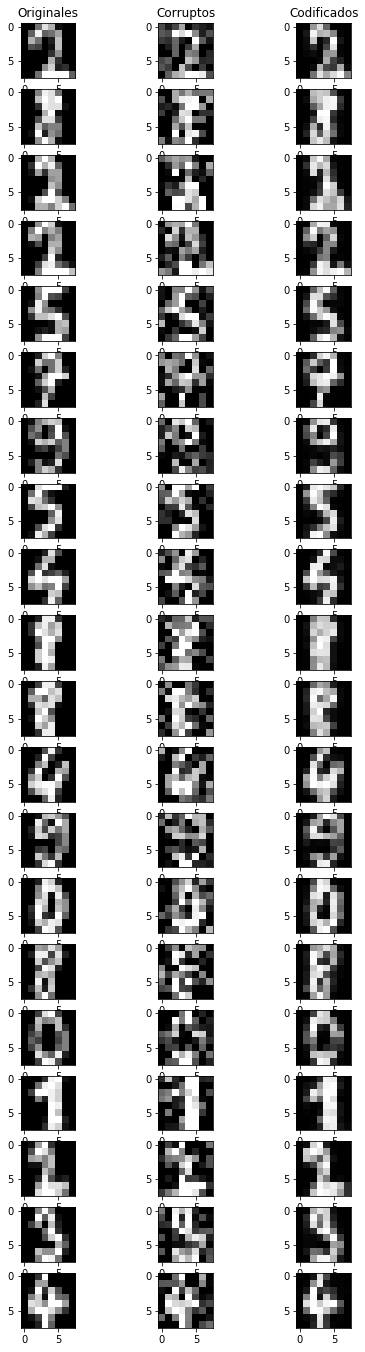

In [30]:
# Mostramos algunos datos
fig = plt.figure(figsize=(7,24))
for i in range(20):
    fig.add_subplot(20,3,1+i*3)
    first_image = np.array(X_test[i], dtype='float64')
    if i == 0: plt.title("Originales")  
    pixels = first_image.reshape((8, 8))
    plt.imshow(pixels, cmap='gray')
    
    fig.add_subplot(20,3,2+i*3)
    if i == 0: plt.title("Corruptos")
    first_image = np.array(X_test_c[i], dtype='float64')
    pixels = first_image.reshape((8, 8))
    plt.imshow(pixels, cmap='gray')
               
    fig.add_subplot(20,3,3+i*3)
    if i == 0: plt.title("Codificados")
    first_image = np.array(mlp.predict(X_test_c[i]), dtype='float64')
    pixels = first_image.reshape((8, 8))
    plt.imshow(pixels, cmap='gray')
               
plt.show()